## This document is to test importance sampling using rejection sampling

## TODO: Choose from ghost walkers with largest local loss

Consider the sampling of points in our deep learning method for solving PDEs
  - We first define a bounding box that contains our domain
  - We define the domain through signed distance functions
  - We sample the domain by sampling uniformly points in the bounding box, and then rejecting points outside the domain
    + There might be a better way to do this. Right now we have to pass each point through every signed distance function

Rejection sampling for importance sampling:
  - At each point, there is some loss that the neural network is making.
  - This loss can be used as a rating for how important the region is.
  - Thus, the loss is proportional to the probability density that we would like to sample from
  - Use rejection sampling. For each point, sample uniformly a number from 0 to the maximum of the loss (the sample max should work fine)
  - If sampled value is greater than the loss at that point, then resample the point.

Metropolis-Hastings for importance sampling:
  - Original Metroplis-Hastings picks a random direction to move
  - To accept the move, take the ratio between the probability density at the new point and the old point
  - If the ratio is greater than 1, accept the step
  - If the ratio is less than 1, still a chance to accept: sample uniform and if ratio is bigger, then accept
  - If we use ghost walkers, we are going to be moving in the current fluid direction. May be necessary to use Girsanov theorem
  - Maybe can do better: We know the average at the old location and the values at the ghost walker locations. Find the ghost walker with the biggest difference and go there.


In [1]:
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import DRLPDE_nn
import DRLPDE_functions.DefineDomain

torch.set_default_dtype(torch.float64)

import importlib
param = 'JCPexample6'
DRLPDE_param = importlib.import_module("." + param, package='examples')

DRLPDE_param_solver = importlib.import_module('DRLPDE_param_solver')
    
### Use cuda
dev = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

boundingbox = DRLPDE_param.boundingbox
list_of_dirichlet_boundaries = DRLPDE_param.list_of_dirichlet_boundaries
list_of_periodic_boundaries = []
pde_type = DRLPDE_param.pde_type
is_unsteady = DRLPDE_param.is_unsteady
output_dim = DRLPDE_param.output_dim

there_are_boundaries = bool(list_of_dirichlet_boundaries)

nn_param = {'depth': DRLPDE_param_solver.nn_depth,
            'width': DRLPDE_param_solver.nn_width,
            'x_dim':DRLPDE_param.x_dim,
            'is_unsteady':DRLPDE_param.is_unsteady,
            'output_dim':DRLPDE_param.output_dim
            }

### Import functions
if is_unsteady:
    # Include time range in bounding box
    boundingbox.append(DRLPDE_param.time_range)
    init_con = DRLPDE_param.init_con

### Organize parameters related to deep learning solver
num_walkers = 10**5
num_batch = 10**4
update_walkers_every = 1

num_bdry = DRLPDE_param_solver.num_bdry
num_batch_bdry = DRLPDE_param_solver.num_batch_bdry

num_epoch = DRLPDE_param_solver.num_epoch
update_print_every = DRLPDE_param_solver.update_print_every

lambda_bell = DRLPDE_param_solver.lambda_bell
lambda_bdry = DRLPDE_param_solver.lambda_bdry

if is_unsteady:
    num_init = DRLPDE_param_solver.num_init
    num_batch_init = DRLPDE_param_solver.num_batch_init
    lambda_init = DRLPDE_param_solver.lambda_init

################ Preparing the model #################

### Make boundaries defining the domain
Domain = DRLPDE_functions.DefineDomain.Domain(is_unsteady, boundingbox, 
                                                list_of_dirichlet_boundaries,
                                                list_of_periodic_boundaries)

### Initialize the Model
MyNeuralNetwork = DRLPDE_nn.IncompressibleNN

#model = MyNeuralNetwork(**nn_param).to(dev)
model = MyNeuralNetwork(**nn_param)
mseloss = nn.MSELoss(reduction = 'mean')
optimizer = optim.Adam(model.parameters(), lr=DRLPDE_param_solver.learning_rate, betas=DRLPDE_param_solver.adam_beta, weight_decay=DRLPDE_param_solver.weight_decay)

InPoints = DRLPDE_functions.DefineDomain.Walker_Data(num_walkers, boundingbox, Domain.boundaries)
InPoints_batch = torch.utils.data.DataLoader(InPoints, batch_size=num_batch, shuffle=True)

if there_are_boundaries:
    BPoints = DRLPDE_functions.DefineDomain.Boundary_Data(num_bdry, boundingbox, Domain.boundaries, is_unsteady)
    BPoints_batch = torch.utils.data.DataLoader(BPoints, batch_size=num_batch_bdry, shuffle=True)

if is_unsteady:
    InitPoints = DRLPDE_functions.DefineDomain.Initial_Data(num_init, boundingbox, Domain.boundaries, init_con)
    InitPoints_batch = torch.utils.data.DataLoader(InitPoints, batch_size=num_batch_init, shuffle=True)

def train_interior(Batch, model, max_loss, do_resample=False):

    ### Indices to resample
    ### dtype might be unnecessarily big
    resample_index = torch.tensor([], dtype=torch.int64)

    for X, index in Batch:
        X.requires_grad_(True)
        #X.to(dev).requires_grad_(True)
        U = model(X)

        Target = DRLPDE_nn.autodiff_vB(U, X)

        loss = torch.norm(Target, dim=1)

        if do_resample:
            ### Rejection sampling ###
            # generate uniform( max_loss )
            # Compare sample < uniform
            # Then resample
            check_sample = max_loss*torch.rand(X.size(0), device=X.device)
            resample_index = torch.cat( (resample_index, index[loss < check_sample]))

            ### Recalculate max loss
            max_loss = torch.max( max_loss, torch.sqrt( torch.max(loss).data ))

        loss = torch.mean( loss )

    return loss, max_loss, resample_index



In [3]:
###
### Importance Sampling: Rejection and Metropolis-Hastings
###

### TODO: Make sure to save max error throughout batches
### Calculate max and min error - Maybe get an idea of distribution
### 

#start_time = time.time()

#ErrorTracker = torch.zeros(2, )

# First step
loss, max_loss, resample_index = train_interior(InPoints_batch, model, torch.tensor([100]))

loss.backward

# Boundary Points
if there_are_boundaries:
    for Xbdry, Ubtrue in BPoints_batch:
        Xbdry = Xbdry.requires_grad_(True)
        Ubtrue = Ubtrue.detach()

        #Xbdry = Xbdry.to(dev).requires_grad_(True)
        #Ubtrue = Ubtrue.to(dev).detach()
        Ubdry = model(Xbdry)
        loss = lambda_bdry*mseloss(Ubdry, Ubtrue)
        loss.backward()

# Initial Points
    if is_unsteady:
        for Xinit, Uinit_true in InitPoints_batch:
            Xinit = Xinit.requires_grad_(True)
            Uinit_true = Uinit_true.detach()
            #Xinit = Xinit.to(dev).requires_grad_(True)
            #Uinit_true = Uinit_true.to(dev).detach()
            Uinit = model(Xinit)
            loss = lambda_init*mseloss(Uinit, Uinit_true)
            loss.backward()

# Make optimization step
optimizer.step()
optimizer.zero_grad()

print('No errors in first epoch')
start_time = time.time()

for step in range(num_epoch):

    do_resample = (step+1) % update_walkers_every == 0 
    loss, max_loss, resample_index = train_interior(InPoints_batch, model, max_loss, do_resample)

    loss.backward

    # Boundary Points
    if there_are_boundaries:
        for Xbdry, Ubtrue in BPoints_batch:
            Xbdry = Xbdry.requires_grad_(True)
            Ubtrue = Ubtrue.detach()
            #Xbdry = Xbdry.to(dev).requires_grad_(True)
            #Ubtrue = Ubtrue.to(dev).detach()

            Ubdry = model(Xbdry)
            loss = lambda_bdry*mseloss(Ubdry, Ubtrue)
            loss.backward()

    # Initial Points
    if is_unsteady:
        for Xinit, Uinit_true in InitPoints_batch:
            Xinit = Xinit.requires_grad_(True)
            Uinit_true = Uinit_true.detach()
            #Xinit = Xinit.to(dev).requires_grad_(True)
            #Uinit_true = Uinit_true.to(dev).detach()
            Uinit = model(Xinit)
            loss = lambda_init*mseloss(Uinit, Uinit_true)
            loss.backward()

    # Make optimization step
    optimizer.step()
    optimizer.zero_grad()

    # Update walkers
    if do_resample and any(resample_index):
        InPoints.location[resample_index,:] = DRLPDE_functions.DefineDomain.generate_interior_points(resample_index.size(0), boundingbox, Domain.boundaries)
        InPoints_Batch = torch.utils.data.DataLoader(InPoints, batch_size=num_batch, shuffle=True)

    # Print statements
    if step == 0:
        current_time = time.time()
        print('Approx time: {:.0f} minutes'.format((current_time - start_time)*num_epoch/60))
    if (step+1) % update_print_every == 0:
        current_time = time.time()
        print('step = {0}/{1}, {2:2.3f} s/step, time-to-go:{3:2.0f} min'.format(
                step+1, num_epoch, (current_time - start_time) / (step + 1), 
            (current_time - start_time) / (step + 1) * (num_epoch - step - 1)/60))


No errors in first epoch
Approx time: 54 minutes
step = 100/1000, 3.608 s/step, time-to-go:54 min
step = 200/1000, 3.622 s/step, time-to-go:48 min
step = 300/1000, 3.616 s/step, time-to-go:42 min


KeyboardInterrupt: 

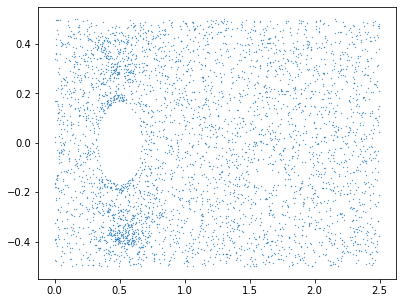

In [3]:
### Plotting

Xplot = InPoints.location

import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6.4, 5.0])
ax.scatter(Xplot[:,0].detach().numpy(), Xplot[:,1].detach().numpy(), s=0.1, marker='o')

(array([ 97.,  93.,  94.,  98., 103., 114., 103.,  92., 109.,  97.]),
 array([0.00199952, 0.10172164, 0.20144376, 0.30116588, 0.400888  ,
        0.50061013, 0.60033225, 0.70005437, 0.79977649, 0.89949861,
        0.99922073]),
 <BarContainer object of 10 artists>)

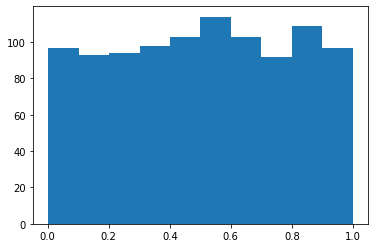

In [4]:
## Test the above in 1 dimension
import numpy as np
import torch
import matplotlib.pyplot as plt

numpts = 1000
numsteps = 10

## For this to be a probability density multiply by 120
target = lambda x: x*(1-x)*(x - 0.5)**2

X = torch.rand(numpts)
plt.hist(X.numpy())


(array([ 98., 284., 102.,  18.,  17.,  10.,  32.,  73., 264., 102.]),
 array([0.00567002, 0.10375735, 0.20184467, 0.299932  , 0.39801932,
        0.49610665, 0.59419397, 0.69228129, 0.79036862, 0.88845594,
        0.98654327]),
 <BarContainer object of 10 artists>)

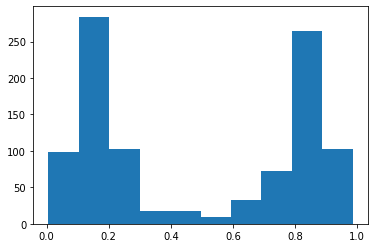

In [5]:
for steps in range(numsteps):
    ## Evaluate the target distribution
    Y = target(X)

    ## Calculate maximum
    alpha = torch.max(Y)

    ## New sample from 0 to alpha
    NewSample = torch.rand(numpts)*alpha

    ## Find indices such that Y < alpha
    indices = Y < NewSample

    ## Resample
    X[indices] = torch.rand(torch.sum(indices))

plt.hist(X.numpy())